In [3]:
import os
import warnings
import pandas as pd
from MCP import Dataset, TaskHandler

dataset = Dataset.get()

if 'sentiment_scores.parquet' not in os.listdir():
    commodities_datasets = {k:dataset[dataset.TRADE_12 == k] for k in dataset.TRADE_12.unique()}
    commodity_list = list(commodities_datasets.keys())
    
    arr = list()
    start = '2010-01-05'
    end = '2021-09-28'
    
    for commodity, df_commodity in commodities_datasets.items():
        print(commodity)
        kpis_df = TaskHandler('sentiment_scores').simple_retrain(df_commodity, start, end)
        arr.append(kpis_df)
    
    names = ('DATE', 'TRADE_ID', 'BEARISH_SCORE', 'NEUTRAL_SCORE', 'BULLISH_SCORE')
    sentiment_scores = pd.concat(arr).rename(columns={i:d for i,d in enumerate(names)})
    sentiment_scores.to_parquet('sentiment_scores.parquet', index=False)

Precious Metals
Oilseeds
Softs
Grains
Metals
Energy
Livestock
Gas
Dairy
Emissions
Industrial Material
Coal
Fertilizer


In [4]:
join_cols = ['DATE', 'TRADE_ID']
sentiment_scores = pd.read_parquet('sentiment_scores.parquet')

enhanced_dataset = pd.merge(dataset.reset_index(),
                            sentiment_scores,
                            how='left',
                            left_on=join_cols,
                            right_on=join_cols).fillna(-1)

enhanced_dataset = enhanced_dataset[enhanced_dataset['DATE'] >= sentiment_scores['DATE'].min()]

In [5]:
from MCP import TimeFolder

start_date = '2010-01-05'
end_date = '2021-09-28'
cv_folds = 5
train_size, test_size = TimeFolder.sizes_calculator(start_date,
                                                    end_date,
                                                    cv_folds=cv_folds,
                                                    space_to_fill=0.5,    # <-- This is the fraction of the period to be used for testing/validation
                                                    period_type='weeks', #     in the moving window. In other words, 50% of the periods will be used
                                                    periods=1)           #     to construct 5 folds that will be used to validate/evaluate a model.

In [6]:
TimeFolder(train_size,
           test_size,
           period_type='weeks').get_time_splits(start_date, end_date)


[[datetime.datetime(2010, 1, 5, 0, 0),
  datetime.datetime(2015, 11, 24, 0, 0),
  datetime.datetime(2017, 1, 24, 0, 0)],
 [datetime.datetime(2011, 3, 8, 0, 0),
  datetime.datetime(2017, 1, 24, 0, 0),
  datetime.datetime(2018, 3, 27, 0, 0)],
 [datetime.datetime(2012, 5, 8, 0, 0),
  datetime.datetime(2018, 3, 27, 0, 0),
  datetime.datetime(2019, 5, 28, 0, 0)],
 [datetime.datetime(2013, 7, 9, 0, 0),
  datetime.datetime(2019, 5, 28, 0, 0),
  datetime.datetime(2020, 7, 28, 0, 0)],
 [datetime.datetime(2014, 9, 9, 0, 0),
  datetime.datetime(2020, 7, 28, 0, 0),
  datetime.datetime(2021, 9, 28, 0, 0)]]

In [7]:
from MCP import TaskHandler

train_start = enhanced_dataset['DATE'].min().strftime('%Y-%m-%d')
train_end = '2018-03-27'
test_end = '2021-09-28'

model, df_test = TaskHandler('PoC').train_with_best_params(enhanced_dataset, train_start, train_end, test_end)

[I 2026-01-23 19:05:12,701] A new study created in memory with name: no-name-d52e9693-6d14-4b34-ae8a-fb05f527c7ec


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-23 19:05:13,368] Trial 0 finished with value: 0.27004247876201076 and parameters: {'n_estimators': 112, 'learning_rate': 0.14162869330215896, 'max_depth': 5, 'min_child_weight': 32, 'subsample': 0.21917194096860496, 'colsample_bytree': 0.7842529931542698, 'gamma': 8.275118661702118, 'reg_alpha': 0.11778057302486783, 'reg_lambda': 9.493055300436465}. Best is trial 0 with value: 0.27004247876201076.
[I 2026-01-23 19:05:16,099] Trial 1 finished with value: 0.3024128137138428 and parameters: {'n_estimators': 177, 'learning_rate': 0.21139727990348692, 'max_depth': 6, 'min_child_weight': 80, 'subsample': 0.6653384466797035, 'colsample_bytree': 0.5339787120655476, 'gamma': 0.060695103580138396, 'reg_alpha': 0.3213115821780321, 'reg_lambda': 0.23655111317203137}. Best is trial 0 with value: 0.27004247876201076.
[I 2026-01-23 19:05:17,824] Trial 2 finished with value: 0.26969004914442885 and parameters: {'n_estimators': 74, 'learning_rate': 0.010262698608706497, 'max_depth': 6, 'min_

<Axes: title={'center': 'Monthly MAE'}, xlabel='DATE'>

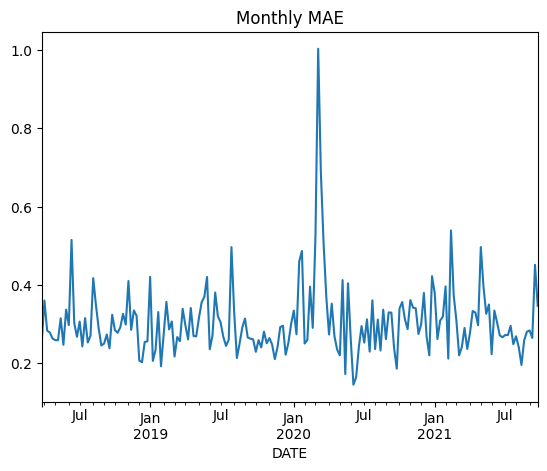

In [8]:
from sklearn.metrics import mean_absolute_error

def group_mae(df):
    y_true = df['y_true'].values
    y_pred = df['y_pred'].values
    return mean_absolute_error(y_true, y_pred)

df_test.groupby('DATE').apply(group_mae).plot(title='Monthly MAE')